In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Semantic analysis using Latent Dirichlet allocation

https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

We'll use the package lda (simpler than gensim).
Other packages:
- http://www.clips.ua.ac.be/pattern
- https://radimrehurek.com/gensim/
- Package frog

(Very) basic (approximate) theory:
1. Starts with a random guess of the topics of every article. Using that you know the words in every topic
1. See the articles where the topics are contradictory but the words similar
1. Change the topics
1. Go to step 1

In [1]:
import numpy as np
import lda
import lda.datasets
X = lda.datasets.load_reuters()
vocab = lda.datasets.load_reuters_vocab()
titles = lda.datasets.load_reuters_titles()
print(X.shape)
print(X)
#(395, 4258)
#84010
model = lda.LDA(n_topics=20, n_iter=1500, random_state=1)
model.fit(X)  # model.fit_transform(X) is also available
topic_word = model.topic_word_  # model.components_ also works
n_top_words = 8
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))


(395, 4258)
[[1 0 1 ..., 0 0 0]
 [7 0 2 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [1 0 1 ..., 0 0 0]
 [1 0 1 ..., 0 0 0]
 [1 0 1 ..., 0 0 0]]
Topic 0: british churchill sale million major letters west britain
Topic 1: church government political country state people party against
Topic 2: elvis king fans presley life concert young death
Topic 3: yeltsin russian russia president kremlin moscow michael operation
Topic 4: pope vatican paul john surgery hospital pontiff rome
Topic 5: family funeral police miami versace cunanan city service
Topic 6: simpson former years court president wife south church
Topic 7: order mother successor election nuns church nirmala head
Topic 8: charles prince diana royal king queen parker bowles
Topic 9: film french france against bardot paris poster animal
Topic 10: germany german war nazi letter christian book jews
Topic 11: east peace prize award timor quebec belo leader
Topic 12: n't life show told very love television father
Topic 13: years year time last

In [6]:
doc_topic = model.doc_topic_
for i in range(5):
    print("{} (top topic: {})".format(titles[i], doc_topic[i].argmax()))

0 UK: Prince Charles spearheads British royal revolution. LONDON 1996-08-20 (top topic: 8)
1 GERMANY: Historic Dresden church rising from WW2 ashes. DRESDEN, Germany 1996-08-21 (top topic: 13)
2 INDIA: Mother Teresa's condition said still unstable. CALCUTTA 1996-08-23 (top topic: 14)
3 UK: Palace warns British weekly over Charles pictures. LONDON 1996-08-25 (top topic: 8)
4 INDIA: Mother Teresa, slightly stronger, blesses nuns. CALCUTTA 1996-08-25 (top topic: 14)


## Big problem. Find the correct number of topics

Usually the problem is ignored. Most of the times people choose 10,20,50,100 topics
But that's cheating.

Explanation: https://medium.com/@javiergb_com/sentiment-and-semantic-analysis-of-facebook-conversations-eng-8f1f51292241#.pzi58hkzu

In [6]:
from matplotlib import cm
import lda
import pylab as plt
from collections import Counter
import bisect
import re
import pickle
import string

#Delete punctuation
def remove_punctuation(string_to_remove):
    transtable = {ord(c): None for c in string.punctuation}
    return string_to_remove.translate(transtable).lower()

def remove_stop_words(text,cached_stop):
    text = ' '.join([word for word in text.lower().split() if word not in cached_stop])
    return text

#Remove endings
def stem_string(string_to_stem,language="english"):
    from nltk.stem.snowball import SnowballStemmer
    stemmer = SnowballStemmer(language)
    return " ".join([stemmer.stem(word) for word in string_to_stem.split(" ")])

def bi_contains(lst, item):
    """ efficient `item in lst` for sorted lists """
    pos = bisect.bisect_left(lst, item)
    return [((item <= lst[-1]) and (lst[pos] == item)),pos]

def create_dictionary(lang,cached_stop):
    """
    top 5000 words
    """
    from labMTsimple.storyLab import emotionFileReader, emotion, stopper, emotionV
    labMT,labMTvector,labMTwordList = emotionFileReader(stopval=0.0,lang=lang,returnVector=True)
    vocab = sorted(list(set(labMTwordList) - set(cached_stop)))
    pickle.dump(vocab,open('./data/vocab.txt',"wb+"))
    
def create_corpus(all_articles,language="english"):
    vocab = pickle.load(open('./data/vocab.txt',"rb+"))
    len_vocab = len(vocab)
    print("Number of articles: {0}".format(len(all_articles)))
    allMessages = np.zeros((len(all_articles),len_vocab))
    j = -1
    for mess in all_articles:
        mess = remove_stop_words(remove_punctuation(mess),cached_stop)
        j += 1
        # Kind-of efficient way to count words (better to use a dictionary)
        file = re.split(' |\n',mess)
        c = Counter(file)
        del c['']
        values = np.zeros(len_vocab)
        for word in c:
            pos = bi_contains(vocab, word)
            if pos[0]:
                values[pos[1]] = c[word]
        allMessages[j,:] += values
        
    allMessages = np.array(allMessages,dtype=int)
    pickle.dump(allMessages, open('./data/corpus.dat',"wb+"))

def lda_run(allMessages,vocab,topicNum=10,n_iter=1000):
    print(topicNum)
    model = lda.LDA(n_topics=topicNum, n_iter=n_iter, random_state=1)
    
    model.fit(allMessages)
    topic_word = model.topic_word_
    print(model.loglikelihood())
    np.savetxt("./data/ldaTopics"+str(topicNum)+".dat",np.asarray(topic_word))
    for i, topic_dist in enumerate(topic_word):
        topic_words = np.array(vocab)[np.argsort(topic_dist)][:]#-[:n_top_words:-1]
        freq_words = np.array(topic_dist)[np.argsort(topic_dist)][:]#-n_top_words:-1]

        print('Topic {}: {}'.format(i, ' '.join(topic_words[::-1][:5])))
        print('Topic {}: {}'.format(i, ' '.join([str(_) for _ in freq_words[::-1][:5]])))


    doc_topic = model.doc_topic_

    allDisSorted = []
    for i in range(allMessages.shape[0]):
        allDisSorted.append(doc_topic[i])

    allDisSorted = np.asarray(allDisSorted)
    np.savetxt("./data/allDistComb1Day"+str(topicNum)+".dat",allDisSorted)
    return model.loglikelihood()
    

def plotNumTopics(x,y,ax2,loglikelihood=False):
    from statsmodels.nonparametric.smoothers_lowess import lowess
    import pylab as plt
    from scipy.misc import comb
    x = np.asarray(x)
    if loglikelihood:
        y = np.asarray(y)
    else:
        y = np.asarray(y)/comb(x,2)
            
    a = lowess(y,x,frac = 0.3)
    ax2.plot(x,y,'.',linewidth=2,markersize=7,color='orange')

    ax2.plot(x,a[:,1],color='orange',linewidth=2,label='Distance')
    ax2.set_xlabel('Number of Topics',fontsize=12)
    ax2.set_ylabel('Average distance between topic',fontsize=12)



def find_distances(tit="",retTopics = False):
    from scipy.stats import pearsonr,spearmanr,kendalltau,entropy
    import pylab as plt
    from scipy.spatial.distance import pdist, squareform
    from scipy.cluster.hierarchy import linkage, dendrogram,leaders,fcluster


    vocab = sorted(pickle.load(open('./data/vocab.txt',"rb+")))

    def KL_H(u,v):
        return entropy(u,v)*entropy(v,u)/entropy(u)/entropy(v)


    varValues = np.transpose(np.loadtxt("./data/allDistComb1Day"+tit+".dat"))
    data_dist_a = pdist(varValues,lambda u,v: KL_H(u,v))


    varValues2 = (np.loadtxt("./data/ldaTopics"+tit+".dat"))
    
    data_dist_b = pdist(varValues2,lambda u,v: KL_H(u,v))

    return np.mean(data_dist_a),np.mean(data_dist_b)


In [94]:
import pandas as pd
import re
from nltk.corpus import stopwords
filenames = ["./data/Pablo_Iglesias_Podemos.csv","./data/Albert_Rivera_Ciudadanos.csv","./data/Mariano_Rajoy_PP.csv","./data/Pedro_Sanchez_PSOE.csv"]

separator_csv = "\t" #tab
header = None
index_col = None 
columns_csv = ["Date","Newspaper","Article"]
column_text = "Article" #leave empty to not get the valence
column_date = "Date" #leave empty to not parse the date
language = "spanish"


all_messages = []
## Fill up
for filename in filenames:
    print(filename)
    df = pd.read_csv(filename,sep=separator_csv,header=header,index_col=index_col)
    df.columns = columns_csv
    all_messages = all_messages + [article for article in df[column_text].values]
    
extra_stop_words = [_.lower() for _ in ["elpais.com","elpais","Podemos","Pablo","Iglesias","Ciudadanos","Albert","Rivera","Pedro","Sanchez","Sánchez","PSOE","Mariano","Rajoy","PP"]]
cached_stop = set(stopwords.words(language) + extra_stop_words)

create_dictionary(lang=language, cached_stop=cached_stop)
create_corpus(all_messages,language=language)


./data/Pablo_Iglesias_Podemos.csv
./data/Albert_Rivera_Ciudadanos.csv
./data/Mariano_Rajoy_PP.csv
./data/Pedro_Sanchez_PSOE.csv
Number of articles: 2803


In [7]:
def find_number_topics(range_lookup,n_iter=1000):
    allMessages =  pickle.load(open('./data/corpus.dat',"rb+"))
    vocab = pickle.load(open('./data/vocab.txt',"rb+"))
        
    distances = []
    for i in range_lookup:
        loglikelihood = lda_run(allMessages,vocab,topicNum = i,n_iter=n_iter)  
        freq_distance, topic_distance = find_distances(tit=str(i),retTopics=True)
        distances.append([loglikelihood,freq_distance,topic_distance])
    
    fig = plt.figure(figsize = (15,5))
    loglikelihood,freq_distance,topic_distance = zip(*distances)
    ax = fig.add_subplot(1,3,1)
    plotNumTopics(range_lookup, loglikelihood,ax,loglikelihood=True)
    ax = fig.add_subplot(1,3,2)
    plotNumTopics(range_lookup, freq_distance,ax,loglikelihood=True)
    ax =fig.add_subplot(1,3,3)
    plotNumTopics(range_lookup, topic_distance,ax,loglikelihood=True)
    plt.show()
    




2
-3440573.1760276067
Topic 0: debate campaña país política gobierno
Topic 0: 0.0117660677649 0.00917084327794 0.00752570097313 0.00710566463999 0.00666062614416
Topic 1: partido gobierno si presidente elecciones
Topic 1: 0.014214360573 0.0132010466655 0.0114097949156 0.0104204175571 0.00937119882615
12


-3483789.0754104587
Topic 0: años españa tres campaña gobierno
Topic 0: 0.0132403642208 0.0112477944087 0.00896682633443 0.00804919549994 0.00694803849855
Topic 1: gobierno josé francia presidente millones
Topic 1: 0.0164002616258 0.00847416123493 0.00824862179291 0.0077331030683 0.00712092458283
Topic 2: congreso dos acuerdo partidos cámara
Topic 2: 0.0211223559253 0.0145583226082 0.0144411077275 0.0133392878493 0.0124718977324
Topic 3: televisión campaña programas política cada
Topic 3: 0.0193821243473 0.0180952083829 0.01333751906 0.0103347151431 0.0074489035866
Topic 4: partido ley campaña cambio candidato
Topic 4: 0.0130207101688 0.0107129323878 0.0105134948018 0.0100861285461 0.00928837820204
Topic 5: elecciones si partido partidos ahora
Topic 5: 0.0161060856967 0.0139349487908 0.0108756195142 0.0108164066895 0.00975057584472
Topic 6: partido votos socialistas elecciones ayer
Topic 6: 0.0249970949636 0.0171872762109 0.0165387099477 0.0157280021186 0.0142687280264
Topic 7: si par


-3457483.195777958
Topic 0: dos españa español ataque líder
Topic 0: 0.0207763088433 0.0177677998717 0.0105587312039 0.00913962319844 0.00891256591757
Topic 1: campaña política programas televisión partidos
Topic 1: 0.0302335335271 0.0210879202176 0.0185248183984 0.0170685105466 0.0153209411244
Topic 2: partido programa reforma socialista líder
Topic 2: 0.0165484964591 0.0149361201984 0.0122629700819 0.0117537986312 0.01154164386
Topic 3: millones gobierno años euros crisis
Topic 3: 0.0203727822346 0.0177375625231 0.0164199526674 0.0130245734238 0.00988258069093
Topic 4: gobierno españa presidente ayer país
Topic 4: 0.0259651162159 0.0179801952232 0.0158074276061 0.013634659989 0.0122766802284
Topic 5: cataluña si constitución r partido
Topic 5: 0.0270060943116 0.0151059592831 0.0145850779519 0.0129823661635 0.0113395865805
Topic 6: campaña cara presidente candidato años
Topic 6: 0.0242910549255 0.0146760960737 0.0146128397654 0.0132212009843 0.012335612669
Topic 7: cataluña gobierno 


-3443164.3970891815
Topic 0: puede si ahora solo presidente
Topic 0: 0.0151632106274 0.0128371684313 0.01094187479 0.0105972759461 0.0102526771023
Topic 1: debate país cara candidatos debates
Topic 1: 0.0453310797494 0.0225165286048 0.0210831536638 0.0197095026786 0.0192317110316
Topic 2: federal general secretario partido comité
Topic 2: 0.0286994922084 0.0265814875806 0.0260519864236 0.0244634829527 0.0226102289034
Topic 3: elecciones mayoría partido gobierno partidos
Topic 3: 0.0274878812386 0.0214347025756 0.0209881566086 0.0202935295489 0.0154807563496
Topic 4: si gobierno política años partidos
Topic 4: 0.0180816117965 0.016060127915 0.0138140347134 0.0137017300533 0.0135332730632
Topic 5: presidente pasado socialista candidato cambio
Topic 5: 0.0164783693272 0.0135795311511 0.0127403937843 0.0123589677085 0.0109095486204
Topic 6: cataluña caso derecho mas millones
Topic 6: 0.0178932016208 0.0134576783419 0.0124051812926 0.012330002932 0.0111271491614
Topic 7: gobierno españa pr


-3420639.513905245
Topic 0: federal comité secretario partido general
Topic 0: 0.0278787966181 0.0223031334266 0.0216302085586 0.0211976140007 0.0210053497527
Topic 1: españa comisión reforma déficit europea
Topic 1: 0.0228104425431 0.0170333774914 0.0153400998038 0.0150412860942 0.0143440541052
Topic 2: programas televisión campaña políticos partidos
Topic 2: 0.033244972677 0.0317240105598 0.0220550371006 0.0162971090856 0.0153193477245
Topic 3: solo aunque encuesta pasado dos
Topic 3: 0.0223255764508 0.0163723728832 0.0148840719912 0.0142462287518 0.0133957710993
Topic 4: campaña primera cara público después
Topic 4: 0.0246662403591 0.0177496182808 0.0140955537865 0.0137040468764 0.0122685215394
Topic 5: ayer gobierno legislatura millones presidente
Topic 5: 0.0227935483167 0.0194128488391 0.0138510529243 0.0135238884587 0.013305778815
Topic 6: líder ayer gobierno socialista partido
Topic 6: 0.030249575079 0.0285210828044 0.0275608093185 0.0264084811354 0.0217031410546
Topic 7: pact


-3413190.7839068924
Topic 0: campaña elecciones partido partidos dos
Topic 0: 0.0329113507465 0.0231479754709 0.0201860526345 0.0195278475597 0.0190890441765
Topic 1: general secretario federal partido díaz
Topic 1: 0.029466215418 0.0252270721419 0.0249490955336 0.0240456715567 0.0217523645385
Topic 2: partido gobierno presidente elecciones si
Topic 2: 0.035727116722 0.034522865716 0.0205736248959 0.0204732706454 0.0185665398858
Topic 3: debate cara debates presidente país
Topic 3: 0.0846648423178 0.0495948351444 0.0374620296324 0.0329454377994 0.0287830884632
Topic 4: programas televisión política partidos campaña
Topic 4: 0.0409623948856 0.0329232967958 0.027053479143 0.0197800094428 0.0160794722268
Topic 5: si sistema partido nuevo gobierno
Topic 5: 0.0165627604249 0.0137145690264 0.0135035918858 0.0130816376046 0.0114993090499
Topic 6: voto campaña socialistas aunque mayoría
Topic 6: 0.0333868521987 0.0212813945487 0.0200071358487 0.0179683219287 0.0168214890987
Topic 7: reforma c


-3395950.1907744473
Topic 0: elecciones mayoría resultado crisis ser
Topic 0: 0.0319911230182 0.0187956094928 0.0167962892617 0.0161964931923 0.0159965611692
Topic 1: gobierno años año millones españa
Topic 1: 0.0301479429139 0.0249202781118 0.0238747451513 0.0196926133096 0.0193441023228
Topic 2: pacto gobierno partidos fuerzas antonio
Topic 2: 0.0270363615197 0.0254841088129 0.0156531750036 0.0150064030424 0.0124193151978
Topic 3: líder socialista pasado españa sino
Topic 3: 0.0245608951805 0.0190419029485 0.0161444320267 0.0158684824151 0.0154545579977
Topic 4: federal congreso comité partido general
Topic 4: 0.0435834449313 0.0319349905307 0.0310633374803 0.0273390017195 0.025437213246
Topic 5: mayoría partido votos si izquierda
Topic 5: 0.0259363570973 0.0228970589725 0.0179328720354 0.0175276322855 0.017223702473
Topic 6: votos elecciones diputados resultado partido
Topic 6: 0.0339592041847 0.0252792434729 0.0211676831358 0.020634703092 0.0198733030296
Topic 7: propuestas único 


-3396264.975911104
Topic 0: debate cara candidatos debates dos
Topic 0: 0.0473887868549 0.0393974231357 0.030985461326 0.0281814740561 0.0269196797847
Topic 1: candidato aunque debate electoral barrio
Topic 1: 0.0313668256069 0.015956270283 0.015956270283 0.0119676559639 0.0119676559639
Topic 2: si barcelona cada puede día
Topic 2: 0.0248354994834 0.0230228216144 0.0190349303025 0.0164971812859 0.0154095745645
Topic 3: partido españa líder solo público
Topic 3: 0.0148542376754 0.0140925795457 0.0106651179618 0.0102842888969 0.0102842888969
Topic 4: campaña si juego izquierda perder
Topic 4: 0.026006597204 0.0198980749428 0.0157093739637 0.0157093739637 0.0136150234742
Topic 5: ayer política campaña debate líder
Topic 5: 0.0292641394019 0.0214938747169 0.0181873791063 0.0166994560815 0.0142195843735
Topic 6: políticos formación puede evaluación país
Topic 6: 0.0164301702364 0.0125284925149 0.0123231410559 0.0102696264657 0.00965357208863
Topic 7: mayoría gobierno si absoluta ser
Topic 


-3385964.0620545903
Topic 0: líder sino partido frente derecha
Topic 0: 0.0230295876309 0.0193529036128 0.0164502583354 0.0162567486503 0.01586972928
Topic 1: congreso diputados cámara grupo propio
Topic 1: 0.0637820859959 0.0518682984945 0.0436850909178 0.0380290503869 0.0238287784156
Topic 2: dos debate gobierno cara candidatos
Topic 2: 0.0286550529998 0.0239088016594 0.0217993566193 0.0198656986658 0.0189867632324
Topic 3: si política razón político sido
Topic 3: 0.0201280012881 0.0179141425323 0.0177128826454 0.0138889447944 0.0132851651337
Topic 4: candidato campaña líder aunque voto
Topic 4: 0.0726659331077 0.0425623352088 0.0336350613491 0.0269915087093 0.0257458425893
Topic 5: políticas fuerzas programa si condición
Topic 5: 0.0280043863943 0.0272211016899 0.0191924334698 0.0189966122937 0.017821685237
Topic 6: déficit impuestos economía fiscal si
Topic 6: 0.0312917617135 0.0304842844742 0.0262450289682 0.0191796031249 0.0173627793367
Topic 7: elecciones gobierno presión españ


-3382876.006279875
Topic 0: política partido razón sido modo
Topic 0: 0.0295813680816 0.0215871239374 0.0154582034269 0.0154582034269 0.0149252538173
Topic 1: si ser gente personaje candidato
Topic 1: 0.0162515169591 0.0156344488553 0.0150173807516 0.0106979040253 0.0104922146574
Topic 2: aunque gobierno solo izquierda dos
Topic 2: 0.0316329048613 0.0213136819436 0.0210893510106 0.0175000560827 0.0166027323508
Topic 3: corrupción guerra gobierno josé dos
Topic 3: 0.0364024546748 0.0212357374525 0.0200690668969 0.0177357257858 0.0165690552302
Topic 4: campaña aunque candidato hizo final
Topic 4: 0.0410767670991 0.0231393142174 0.0218394987912 0.0215795357059 0.0213195726207
Topic 5: juego intentar partidos después perder
Topic 5: 0.0244406482075 0.0220680000949 0.0182717631148 0.0177972334923 0.017559968681
Topic 6: cataluña ahora independencia voto campaña
Topic 6: 0.0352955267739 0.0252343612757 0.0233179487998 0.021880639443 0.0206030311257
Topic 7: cara debate dos candidatos cuatro

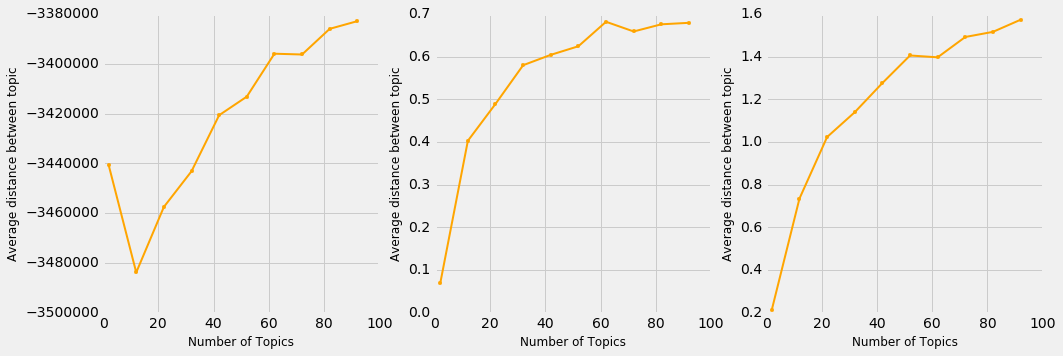

In [125]:
find_number_topics(range(2,100,10),n_iter=100)

5
-3447318.81915702
Topic 0: partido años elecciones votos gobierno
Topic 0: 0.00980778120759 0.00926864632408 0.00832802801666 0.00784624790798 0.00762829976358
Topic 1: debate país gobierno españa candidatos
Topic 1: 0.0168145928584 0.0144629289582 0.00995557314949 0.00854457480937 0.00832900561852
Topic 2: si política partido españa elecciones
Topic 2: 0.0105792576462 0.0092607262018 0.0078391844883 0.00746834751956 0.00680908179736
Topic 3: gobierno partido presidente si congreso
Topic 3: 0.0161147631458 0.0138422666391 0.0126680283226 0.0109895582585 0.0109204854163
Topic 4: debate líder candidato presidente campaña
Topic 4: 0.0206683812606 0.0166758133623 0.0146160433511 0.0145737193098 0.0125985973813
7


-3433678.859431006
Topic 0: partido elecciones campaña dos votos
Topic 0: 0.0161550113512 0.0143922023403 0.011911678232 0.0110554567123 0.0102118266857
Topic 1: gobierno presidente españa tras ayer
Topic 1: 0.0141188722251 0.0122890956612 0.00978162407353 0.00693530497406 0.00641573878923
Topic 2: debate cara país candidatos candidato
Topic 2: 0.0286029520938 0.014147966489 0.0138237106136 0.0120147041506 0.0104275569709
Topic 3: españa política si cataluña gobierno
Topic 3: 0.012458624382 0.0118614854916 0.00979864205188 0.00758651388959 0.00663652020026
Topic 4: años españa gobierno programa reforma
Topic 4: 0.00832739430403 0.00752718825097 0.00732713673771 0.0066769693196 0.00665196288044
Topic 5: gobierno partido presidente congreso si
Topic 5: 0.0173500240418 0.0147602114229 0.0139452354239 0.0128586007587 0.0122881175594
Topic 6: líder candidato presidente ayer socialista
Topic 6: 0.020918902127 0.0169631263591 0.0163150049056 0.0135884249978 0.0127838604349
9


-3433450.814514271
Topic 0: campaña electoral programas política años
Topic 0: 0.0210024525038 0.00859408482118 0.00816775754094 0.0080331278735 0.00794337476187
Topic 1: gobierno socialista partido candidato años
Topic 1: 0.011807097073 0.0106792062528 0.0104152318056 0.00986328523399 0.0087113967368
Topic 2: gobierno españa presidente ayer tras
Topic 2: 0.0167438078344 0.0136558737653 0.0123520793805 0.00974449061096 0.00971018023242
Topic 3: debate país cara candidatos candidato
Topic 3: 0.0342146540164 0.0171949413389 0.0164292730308 0.0125571790154 0.0104133077527
Topic 4: partido elecciones dos congreso votos
Topic 4: 0.018826495841 0.0148669275958 0.0137923979234 0.0134685670632 0.0129092228501
Topic 5: gobierno si partido presidente líder
Topic 5: 0.018203524286 0.0150069482826 0.0140918978999 0.0133720582655 0.0122251951192
Topic 6: españa reforma ley partidos programa
Topic 6: 0.0195433544785 0.0164457343894 0.0107010571333 0.00951832946287 0.00940568873236
Topic 7: política


-3428535.9068643334
Topic 0: madrid elecciones partido años dos
Topic 0: 0.0130525875597 0.0128413840588 0.0117853665542 0.0109616729007 0.00893411929196
Topic 1: gobierno españa millones reforma r
Topic 1: 0.0115542209494 0.00993261654558 0.0097009587736 0.00941138655864 0.00938242933714
Topic 2: gobierno presidente españa tras ayer
Topic 2: 0.0198849266805 0.0176545305394 0.0142522313412 0.0103206856011 0.00982924238358
Topic 3: debate país cara candidatos debates
Topic 3: 0.0382276456426 0.022318483837 0.0210423478633 0.0156258596194 0.0118541688526
Topic 4: líder socialista debate partido candidato
Topic 4: 0.0205332416193 0.0164523108591 0.0152203317617 0.0140910175891 0.0136546916587
Topic 5: gobierno partido elecciones congreso cataluña
Topic 5: 0.0177205720308 0.0170309447743 0.0137926950483 0.0121735701853 0.0118587403508
Topic 6: política si ahora años españa
Topic 6: 0.0185352743476 0.0100620925355 0.00783031696887 0.0075844433895 0.00720617634431
Topic 7: españa cataluña c


-3409540.5356133734
Topic 0: campaña ataque años presidente ayer
Topic 0: 0.0143711228245 0.00839252510737 0.00828282606669 0.0078988794243 0.00713098613953
Topic 1: elecciones partido votos campaña dos
Topic 1: 0.01964017991 0.0194068335482 0.0162566576634 0.015576064108 0.0124842248137
Topic 2: años madrid candidato presidente gobierno
Topic 2: 0.0161349388489 0.00956617414616 0.00849874988197 0.00784187341169 0.00771870907352
Topic 3: gobierno españa r pacto presidente
Topic 3: 0.0221597394398 0.0201528575072 0.0135468711456 0.0133378209443 0.0132542008638
Topic 4: debate líder socialista política cara
Topic 4: 0.0180909841148 0.0112371023466 0.00899910013661 0.00867272481432 0.00750709866326
Topic 5: campaña programas televisión política candidato
Topic 5: 0.0225083656683 0.0162024698859 0.014085161813 0.0125662234128 0.00874586319428
Topic 6: política si españa puede gobierno
Topic 6: 0.0145498052491 0.0130803295254 0.00794623533019 0.00772853522297 0.00676702641609
Topic 7: gobi


-3403756.476949034
Topic 0: debate cara campaña presidente debates
Topic 0: 0.0275833484968 0.0179653810939 0.0171855458991 0.0141528534747 0.0133441354949
Topic 1: elecciones partido votos dos resultado
Topic 1: 0.0211835726911 0.0188840653432 0.0154231906477 0.0117300424828 0.0110099947274
Topic 2: gobierno presidente congreso partido elecciones
Topic 2: 0.0211018981595 0.0178233855312 0.0149621381466 0.0108888345782 0.0107894857107
Topic 3: r ataque va ser policía
Topic 3: 0.0183817731056 0.00816999211424 0.00777286729791 0.00771613518129 0.00720554613172
Topic 4: partido si federal general secretario
Topic 4: 0.0230439842836 0.0199812150152 0.0170351226712 0.0168017688222 0.0153433072658
Topic 5: años madrid gobierno si candidato
Topic 5: 0.0114154014327 0.00904535495074 0.00861004029079 0.0076426743798 0.00691714994655
Topic 6: campaña líder si ayer debate
Topic 6: 0.0190870336277 0.00922094806628 0.00906727072108 0.00879065149974 0.00857550321647
Topic 7: política político españ


-3402418.0547341118
Topic 0: si campaña años líder política
Topic 0: 0.0102716027503 0.00962713530191 0.00930490157774 0.00894238863804 0.00841875883625
Topic 1: años gobierno millones españa programa
Topic 1: 0.0123509605677 0.0122570404843 0.0114117597336 0.0101907986494 0.00972119823242
Topic 2: debate socialista presidente partido cara
Topic 2: 0.0333672024007 0.0192455234708 0.0185136071848 0.0154998342425 0.0127874385944
Topic 3: gobierno candidato ayer hoy madrid
Topic 3: 0.0199729868239 0.0133633799039 0.0112559690019 0.0106333248718 0.00981909793234
Topic 4: elecciones votos resultado partido dos
Topic 4: 0.0214343718089 0.0187159103187 0.0142548453091 0.0138714725348 0.0129653187048
Topic 5: debate país cara candidatos televisión
Topic 5: 0.033314049944 0.0209793302014 0.0168899217693 0.013997413366 0.0105064549484
Topic 6: presidente ataque según policía años
Topic 6: 0.0112483690797 0.00983436919537 0.00970582375134 0.00829182386703 0.00803473297898
Topic 7: congreso mesa 


-3388780.766784442
Topic 0: años dos si día año
Topic 0: 0.0139003433772 0.00859781618249 0.0068989482463 0.006590063167 0.00597229300839
Topic 1: millones gobierno laboral reforma años
Topic 1: 0.0128704404452 0.0124856227846 0.0100484442677 0.0094070815001 0.00923605142874
Topic 2: elecciones gobierno partidos partido líder
Topic 2: 0.0161031919285 0.0149503341428 0.0126818075323 0.0122355400023 0.011008304295
Topic 3: reforma ley constitución partido constitucional
Topic 3: 0.0221018830303 0.0202600928102 0.0192991587823 0.011931997902 0.0118919589841
Topic 4: programas campaña televisión partidos política
Topic 4: 0.0235669577525 0.0230860134527 0.0197194033542 0.0171772691983 0.0151160793421
Topic 5: partido elecciones votos resultado voto
Topic 5: 0.0229309293399 0.021192504353 0.0169982091463 0.0122796270389 0.0118381222803
Topic 6: debate cara país candidatos líder
Topic 6: 0.0548562909483 0.0304808292081 0.0215888731105 0.0208810557097 0.0203944312466
Topic 7: líder candidato


-3377123.015877184
Topic 0: partido si federal general comité
Topic 0: 0.0226774838031 0.0212828978284 0.0172204082499 0.0143402850412 0.0136733091403
Topic 1: años españa solo vida campaña
Topic 1: 0.0158570425596 0.00783323860787 0.00730787049198 0.00716458827856 0.0068302631139
Topic 2: gobierno españa presidente francia tras
Topic 2: 0.019760686725 0.0160185645767 0.0152427587655 0.0113637297093 0.00994902499464
Topic 3: gobierno millones euros años laboral
Topic 3: 0.0170816776365 0.0154451587168 0.0112004377688 0.00910364790295 0.00854109452431
Topic 4: debate cara candidatos candidato dos
Topic 4: 0.0342810511052 0.0152296183039 0.0121959506604 0.0118319105432 0.0115285437789
Topic 5: congreso cámara mesa diputados acuerdo
Topic 5: 0.0339678701122 0.0181375961053 0.0179387233162 0.0177000759694 0.0168250356977
Topic 6: debate país candidatos redes televisión
Topic 6: 0.023615996266 0.022615812899 0.013114070913 0.0123361505165 0.0108358754661
Topic 7: elecciones partido gobiern


-3370456.782519832
Topic 0: presidente ataque policía dijo embajada
Topic 0: 0.0171075637718 0.0136106306766 0.0133270955608 0.0120039316869 0.01134234975
Topic 1: años españa madrid candidato día
Topic 1: 0.0104194351382 0.00992033040733 0.00979555422461 0.00867256858011 0.0083606281233
Topic 2: gobierno españa millones déficit economía
Topic 2: 0.0146476975656 0.0129172409105 0.0119284085361 0.0106305660447 0.0106305660447
Topic 3: gobierno millones venezuela euros cambio
Topic 3: 0.0170517265065 0.0113950237177 0.00937477272176 0.00905153256241 0.00897072252257
Topic 4: política imagen partido dos si
Topic 4: 0.0184425866296 0.00907379819967 0.00839857020472 0.00806095620724 0.00738572821229
Topic 5: congreso mesa cámara diputados acuerdo
Topic 5: 0.0327140223168 0.0183549967328 0.0177723116366 0.0161491174402 0.0161074970762
Topic 6: debate país cara candidatos televisión
Topic 6: 0.0340199717251 0.0218788577575 0.0154823648283 0.0138526851011 0.0118563274353
Topic 7: debate candi


-3371363.4594549816
Topic 0: dos campaña día candidato si
Topic 0: 0.0130355822111 0.0130355822111 0.0109851563816 0.0109119268877 0.00988671397292
Topic 1: campaña cara partido encuestas dos
Topic 1: 0.0242090266235 0.0138422512698 0.0104252694493 0.00949863031152 0.00862990611987
Topic 2: socialista derecha años frente socialistas
Topic 2: 0.0153201841174 0.0113484684071 0.00992999851061 0.00900799307787 0.00879522259339
Topic 3: cataluña partido ley presidente mas
Topic 3: 0.0236636509192 0.0173620890321 0.0149186262595 0.0133110849618 0.011703543664
Topic 4: campaña programas televisión política partidos
Topic 4: 0.0275907631429 0.0218399775446 0.018896123012 0.0138984164801 0.0113653323475
Topic 5: elecciones votos partido resultado dos
Topic 5: 0.0227874036647 0.021395579177 0.0178998339521 0.0149219769087 0.0129798962282
Topic 6: congreso mesa acuerdo cámara grupos
Topic 6: 0.0293177490145 0.0204193838205 0.0188288547761 0.0167224784741 0.0164645548453
Topic 7: si política años


-3359805.627675887
Topic 0: dos debate cara gobierno candidato
Topic 0: 0.0171715286462 0.0163627540641 0.0152429123351 0.0133765094533 0.00902156939597
Topic 1: años elecciones gobierno socialista crisis
Topic 1: 0.0233964029867 0.0163447280492 0.0123905178038 0.0123246142997 0.0104134126812
Topic 2: gobierno presidente ayer pacto francia
Topic 2: 0.0312671551147 0.0173629571996 0.015417810341 0.0149135130073 0.0139049183399
Topic 3: campaña candidato si partido voto
Topic 3: 0.0190074790691 0.0182472179194 0.014065781596 0.0139707489523 0.0137806836648
Topic 4: socialista debate gobierno candidato líder
Topic 4: 0.0190146383928 0.014814786533 0.0138984552181 0.0131348457891 0.0118367097597
Topic 5: partido r gobierno si voto
Topic 5: 0.0170622559558 0.0157948102975 0.0122362128724 0.0120899691426 0.0108712713942
Topic 6: reforma españa laboral programa impuestos
Topic 6: 0.0192305579127 0.0128816228855 0.0127595279811 0.0125153381724 0.011416484033
Topic 7: presidente ataque cara po


-3357755.7682773266
Topic 0: ley cataluña constitución tribunal justicia
Topic 0: 0.0207541252756 0.0170646669803 0.0117149524521 0.0108848243357 0.00977798684708
Topic 1: campaña día electoral elecciones dos
Topic 1: 0.020578785981 0.0147226040489 0.0117131772227 0.011387833782 0.0113064979219
Topic 2: según ataque policía presidente embajada
Topic 2: 0.0140014921661 0.0130804019638 0.0116987666602 0.011238221559 0.0110540035186
Topic 3: gobierno presidente españa francia ayer
Topic 3: 0.0258844621744 0.0161419751307 0.0147584266748 0.0136054696282 0.011818386206
Topic 4: reforma laboral programa gobierno españa
Topic 4: 0.0170944261765 0.0140486209962 0.0131162316552 0.0127432759189 0.0123081608931
Topic 5: mas partido cataluña elecciones españa
Topic 5: 0.0158563808703 0.0137701064695 0.012309714389 0.0113361196687 0.0106406948685
Topic 6: congreso cámara mesa acuerdo presidente
Topic 6: 0.0306280484739 0.0187884273418 0.0187884273418 0.0175998939463 0.0175998939463
Topic 7: gobier


-3344862.0721311397
Topic 0: partido dos años cuatro política
Topic 0: 0.0124582480126 0.0110567827028 0.0104339092318 0.00942173984132 0.00934388065744
Topic 1: debate ayer campaña candidato presidente
Topic 1: 0.0197187421524 0.0162774258954 0.0149753062306 0.0133941609234 0.012929118186
Topic 2: años elecciones año mayor dos
Topic 2: 0.0194745285202 0.0140474233222 0.0107751981292 0.00965785294141 0.00957804257085
Topic 3: españa gobierno programa déficit impuestos
Topic 3: 0.0168065926128 0.0150375551903 0.0148901354051 0.01304738809 0.0122365792713
Topic 4: debate país redes televisión sociales
Topic 4: 0.0236369602071 0.0210242014376 0.0134289724567 0.0129428778019 0.0121529739879
Topic 5: congreso mesa acuerdo grupos dos
Topic 5: 0.035544988912 0.0203940297881 0.0201319024677 0.0196600732908 0.0192930950421
Topic 6: madrid barcelona millones ayer lista
Topic 6: 0.0248015600359 0.0134153922666 0.011321384401 0.0104052559597 0.00968544075594
Topic 7: españa gobierno dijo líder ay


-3352041.4370642286
Topic 0: debate cara país candidatos tres
Topic 0: 0.0388285573689 0.0275711676003 0.0244703297 0.0146285398424 0.0117973400204
Topic 1: elecciones partido si política gobierno
Topic 1: 0.0101131731556 0.009676211165 0.00948894174048 0.00923924917445 0.00911440289144
Topic 2: caso justicia españa dos si
Topic 2: 0.00992484778316 0.00992484778316 0.00858099796355 0.00816750571136 0.00816750571136
Topic 3: presidente candidato años madrid día
Topic 3: 0.0130402801809 0.0117864874579 0.0112849703687 0.010699867098 0.0100311776457
Topic 4: millones gobierno años socialista pasado
Topic 4: 0.0149664847153 0.0120521121325 0.0117370448262 0.010870609734 0.00992540781524
Topic 5: líder gobierno gonzález ayer felipe
Topic 5: 0.03032137366 0.0282785166708 0.0246228778479 0.0198920511359 0.0160213747352
Topic 6: congreso partido elecciones general secretario
Topic 6: 0.0427745475712 0.0269468988927 0.0201449341714 0.018444442991 0.0150434606304
Topic 7: cataluña partido mas i


-3341995.7427503564
Topic 0: debate años campaña candidato solo
Topic 0: 0.0162336497305 0.0124744760652 0.0123890403001 0.0102531461721 0.00948422428597
Topic 1: campaña socialista hoy día dos
Topic 1: 0.0249068912073 0.0155767347537 0.0137261252092 0.013263472823 0.01303214663
Topic 2: único laboral tres contrato reforma
Topic 2: 0.0198974326237 0.016811899518 0.0143647525722 0.0138327641057 0.0137263664124
Topic 3: elecciones mayoría resultado dos partidos
Topic 3: 0.0215800748605 0.0147531721557 0.0137330602572 0.013262239381 0.0118497767524
Topic 4: presidente elecciones funciones proceso ahora
Topic 4: 0.0209604266493 0.0169431231333 0.0117613838155 0.00984006474263 0.00896673789132
Topic 5: votos elecciones partido madrid dos
Topic 5: 0.022178502101 0.0215107766124 0.0189829586916 0.0167890035151 0.0141657962388
Topic 6: millones gobierno caso justicia tribunal
Topic 6: 0.0155681964488 0.013695471517 0.013695471517 0.0111204747358 0.00924774980395
Topic 7: si ser política años 


-3338796.966351952
Topic 0: partido líder madrid candidato hoy
Topic 0: 0.0140589749113 0.0129252780392 0.0129252780392 0.0124717992903 0.0123584296031
Topic 1: debate líder soraya cuatro si
Topic 1: 0.0194643367147 0.0119540497371 0.0102615906999 0.00983847594064 0.00962691856099
Topic 2: campaña cara debate presidente ayer
Topic 2: 0.0174812240211 0.0137209467768 0.0105704442209 0.010163927762 0.00996066953261
Topic 3: millones gobierno mujeres caso pasado
Topic 3: 0.0109892106561 0.00943180736652 0.00925876255656 0.00865310572173 0.00856658331675
Topic 4: r si españa aquí va
Topic 4: 0.0315040788744 0.0161414528377 0.010793703268 0.00952968973329 0.0090435306815
Topic 5: partidos elecciones dos gobierno nuevo
Topic 5: 0.0230117310026 0.0147887557445 0.0141919268951 0.0141919268951 0.0132635264627
Topic 6: laboral reforma fiscal españa gobierno
Topic 6: 0.0166361557802 0.0165601950671 0.0140534915342 0.0129140808374 0.0129140808374
Topic 7: años partido elecciones crisis dos
Topic 7


-3333758.346162513
Topic 0: elecciones presidente dos hace entonces
Topic 0: 0.0128231229262 0.0124316070747 0.0103761488543 0.00929948026271 0.00920160129983
Topic 1: gobierno si elecciones españa partido
Topic 1: 0.0327042342294 0.0243796714176 0.0190876279158 0.0154010358135 0.0124279776664
Topic 2: candidato madrid día hoy campaña
Topic 2: 0.0218743851771 0.0209485342623 0.0138889210365 0.0123844132998 0.0121529505711
Topic 3: programas campaña televisión partidos política
Topic 3: 0.0356079642129 0.0265935749941 0.0238892582284 0.0172411461796 0.0165650669882
Topic 4: ayer debate años campaña líder
Topic 4: 0.0176199902578 0.0150289676329 0.014096199488 0.0130597904381 0.0108833314333
Topic 5: socialista debate líder socialistas política
Topic 5: 0.0196510803352 0.0191384657445 0.0123890403001 0.0117909899442 0.0101677104069
Topic 6: presidente candidato líder violencia escribió
Topic 6: 0.0391396138168 0.0267973431638 0.0245237669909 0.0237117755006 0.0209510044335
Topic 7: gobi


-3330033.650376721
Topic 0: fuerzas socialista políticas si izquierda
Topic 0: 0.0250084399265 0.023132900709 0.0180064268477 0.0166310314215 0.0143803843605
Topic 1: años legislatura personas noviembre millones
Topic 1: 0.0222990852553 0.00832941555738 0.00819509181028 0.00806076806319 0.0075234730748
Topic 2: reforma propuestas laboral contrato único
Topic 2: 0.0264844088731 0.023320482323 0.021445562886 0.0183988188008 0.0179300889415
Topic 3: partido si socialistas gobierno díaz
Topic 3: 0.0224188921327 0.0203290544434 0.0181125599245 0.0177325894356 0.0170993052873
Topic 4: españa pacto gobierno partidos lucha
Topic 4: 0.0269397299003 0.023472354348 0.0221387483663 0.0176933950941 0.0129813206256
Topic 5: elecciones dos ser mayoría gobierno
Topic 5: 0.013837180838 0.0128792958481 0.0113892525304 0.0107506625371 0.0106442308716
Topic 6: programas televisión campaña política partidos
Topic 6: 0.033621921222 0.029110497653 0.0282511788779 0.0195505762807 0.0170800348024
Topic 7: for


-3321983.510434548
Topic 0: candidato madrid campaña día hoy
Topic 0: 0.0305994603926 0.0188149312052 0.018401438953 0.0172643352595 0.0168508430073
Topic 1: si campaña gente ser padres
Topic 1: 0.0183968147971 0.0161288696814 0.00970302518679 0.00882104653067 0.00705708921844
Topic 2: elecciones resultado partido campaña dos
Topic 2: 0.0166555360426 0.0140171658958 0.0135224714932 0.0133575733591 0.012368184554
Topic 3: años campaña ayer debate presidente
Topic 3: 0.0163568824761 0.0131689467338 0.0123373113227 0.00956519328593 0.00873355787489
Topic 4: congreso mesa cámara acuerdo grupos
Topic 4: 0.0339195282077 0.0240511265933 0.022219267611 0.0213919764577 0.0208601464305
Topic 5: candidato cara líder ahora solo
Topic 5: 0.0194697739668 0.014888987503 0.0133143421561 0.0110239489242 0.0100219018853
Topic 6: rey gobierno millones presidente felipe
Topic 6: 0.0282906527245 0.0176266718012 0.0171823392627 0.0143682331857 0.0133314572626
Topic 7: españa socialista partido líder años
T


-3320620.983743284
Topic 0: debate cara candidato presidente país
Topic 0: 0.0677277733242 0.0364115165909 0.0289195891427 0.0272713651041 0.0268967687317
Topic 1: si díaz federal fuerzas socialista
Topic 1: 0.0189932621433 0.0182826540566 0.0167322364129 0.0160216283261 0.0158924268558
Topic 2: campaña cara líder estrategia electoral
Topic 2: 0.0157389350759 0.0139142632317 0.011861507407 0.0108351294947 0.0100368355629
Topic 3: partido voto campaña mayoría si
Topic 3: 0.0305297298545 0.0243546460292 0.0177178736936 0.017602451566 0.0139089434836
Topic 4: pacto gobierno ayer partidos acuerdo
Topic 4: 0.0343771563351 0.0304879119776 0.0222075852811 0.0220821257857 0.0215802878041
Topic 5: votos elecciones madrid resultado diputados
Topic 5: 0.0274546655805 0.0217457680392 0.0198855654695 0.016421739995 0.016421739995
Topic 6: legislatura elecciones años año dos
Topic 6: 0.0141876508746 0.0135012069972 0.0124715411809 0.0106410241743 0.0104122095484
Topic 7: líder socialista cara pacto


-3318170.89987814
Topic 0: debate país televisión programa electoral
Topic 0: 0.0352320943113 0.0302353548955 0.0188868280868 0.0160920416338 0.0154145176453
Topic 1: pacto gobierno partidos presidente ayer
Topic 1: 0.0306580577349 0.0291564998686 0.0234005280478 0.0211481912484 0.018895854449
Topic 2: programas televisión campaña política partidos
Topic 2: 0.0347595677237 0.026804312972 0.0259475932295 0.0187266696856 0.016523676062
Topic 3: cara debate dos candidatos imagen
Topic 3: 0.0211550319208 0.0206807251202 0.0166965479951 0.0105305595872 0.0105305595872
Topic 4: españa gobierno pacto cambio acuerdo
Topic 4: 0.0399000787642 0.0208702001299 0.0131662613475 0.0129937851061 0.0124188643014
Topic 5: candidato cada juego siempre dado
Topic 5: 0.0133184655125 0.0128371331847 0.0118744685289 0.011393136201 0.00994913921735
Topic 6: partido socialista corrupción presidente debate
Topic 6: 0.0214844613878 0.0195888665396 0.0168507850922 0.0161136093179 0.0150605010689
Topic 7: polític


-3315615.6218709676
Topic 0: dos debate candidato gobierno justicia
Topic 0: 0.0170139096889 0.0137790983263 0.0122215965591 0.010184863479 0.0100650556507
Topic 1: ataque policía embajada aseguró alicante
Topic 1: 0.0254726978638 0.0226839199063 0.0223120828453 0.0135739119118 0.0128302377898
Topic 2: debate cara país presidente debates
Topic 2: 0.049856756978 0.041969089272 0.0222499200071 0.0191246177086 0.0179340263567
Topic 3: propuestas único reforma contrato laboral
Topic 3: 0.0252905643566 0.0220147542487 0.0192630737581 0.0180837821193 0.0175596525021
Topic 4: socialista líder pasado socialistas debate
Topic 4: 0.0224268141194 0.0130827662779 0.012203326481 0.011653676608 0.0114338166588
Topic 5: gente años candidato barrio madrid
Topic 5: 0.0138924974597 0.0138924974597 0.011577295587 0.0106769393031 0.0100338276718
Topic 6: millones gobierno grupo empresa euros
Topic 6: 0.0189408990475 0.0144846538054 0.0144846538054 0.0115138236441 0.0111424698739
Topic 7: partido federal 

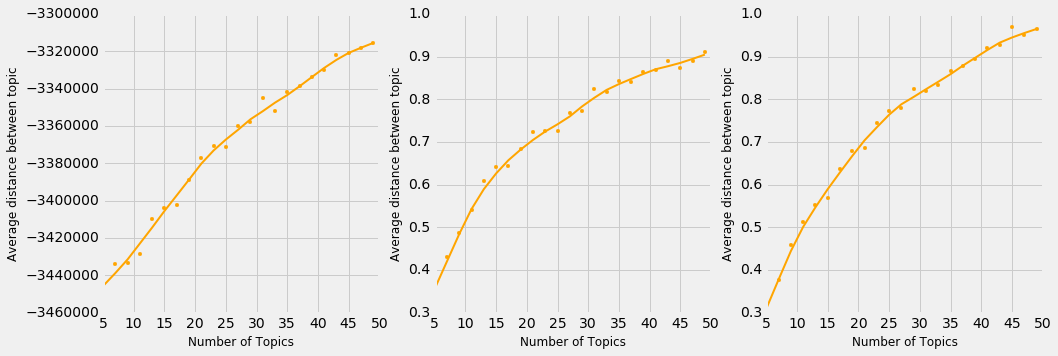

In [128]:
find_number_topics(range(5,50,2),n_iter=1000)

20
-3375003.3342432347
Topic 0: campaña partido si voto mejor
Topic 0: 0.0210252545037 0.0120996494221 0.00828147391492 0.00813271383023 0.00803354044043
Topic 1: españa dos años electoral socialista
Topic 1: 0.0134513928091 0.0107333765428 0.0107333765428 0.0105242983685 0.0104546056437
Topic 2: gobierno españa presidente francia pacto
Topic 2: 0.023579049106 0.0207113915043 0.0158788573978 0.0137546665817 0.0121615234697
Topic 3: cataluña dos mas gobierno campaña
Topic 3: 0.0279264119095 0.0148667970908 0.0126987977928 0.0119761313601 0.0105307984948
Topic 4: españa partido cataluña gobierno pacto
Topic 4: 0.0179200374581 0.0114169029472 0.0109255550064 0.00971163656438 0.0094226083639
Topic 5: años ser si candidato gente
Topic 5: 0.0116546041704 0.00860494371743 0.0084415690503 0.00746132104756 0.00702565526856
Topic 6: debate país cara candidatos televisión
Topic 6: 0.0336563957209 0.0181563674203 0.0161100153694 0.0146732149932 0.0122350082943
Topic 7: ataque embajada policía mejo

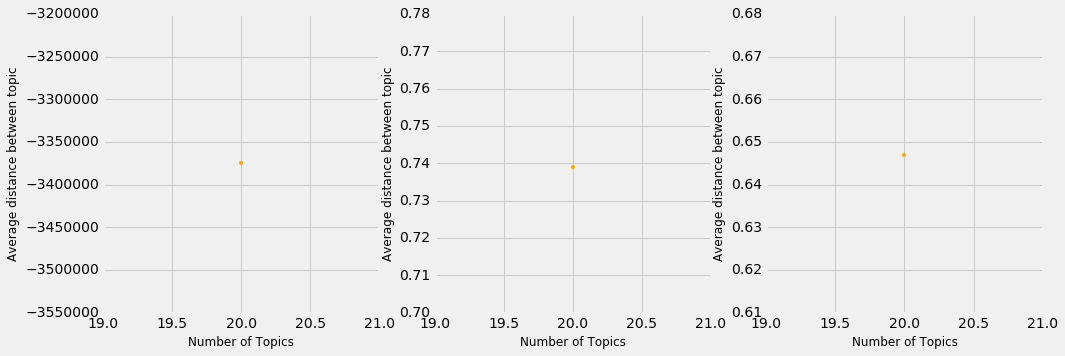

In [130]:
find_number_topics([20],n_iter=10000)

In [8]:
def correlationMerge(tit="",threshold=0.7):
    """
    Stolen code from Prof. Bagrow's slides to cluster and plot accordint to distance.
    """
    from scipy.stats import pearsonr,spearmanr,kendalltau,entropy
    import pylab as plt
    from scipy.spatial.distance import pdist, squareform
    from scipy.cluster.hierarchy import linkage, dendrogram,leaders,fcluster

    vocab = pickle.load(open('./data/vocab.txt',"rb+"))

    def KL_E(u,v):
        return entropy(u,v)*entropy(v,u)/entropy(u)/entropy(v)

    varValues = np.transpose(np.loadtxt("./data/allDistComb1Day"+str(tit)+".dat"))
    data_dist_a = pdist(varValues,lambda u,v: KL_E(u,v))

    varValues2 = (np.loadtxt("./data/ldaTopics"+str(tit)+".dat"))
    data_dist_b = pdist(varValues2,lambda u,v: KL_E(u,v))
    data_dist = data_dist_a*1 * data_dist_b*1

    #print(data_dist)
    fig = plt.figure(figsize=(8,8))

    # plot first dendrogram:
    ax1 = fig.add_axes([0.05,0.1,0.2,0.6])
    Y = linkage(data_dist, method='weighted') # method?

    t = max(Y[:, 2]) * threshold
    Z1 = dendrogram(Y, orientation='right',
                leaf_font_size=18,color_threshold=t) # adding/removing the axes
                #labels=["Profit","Decay","Profit \n(Ratio)","IMDB rating","Metascore","RottenT \nAudience","RottenT \nCritics","Profit \n(Deviation)"],
    ax1.set_xticks([]) # turn off xticks

    # plot second dendrogram:
    ax2 = fig.add_axes([0.32,0.71,0.58,0.2])
    Z2 = dendrogram(Y,color_threshold=t)
    ax2.set_xticks([])
    ax2.set_yticks([])

    clusters = fcluster(Y,t=t,criterion='distance')
    #print( clusters)
    lisTop = np.asarray(range(len(clusters)))

    #print(np.unique(clusters))
    prov = 0
    for g in np.unique(clusters):
        group = lisTop[clusters==g]
        for i2 in group:
            topic_words = np.array(vocab)[np.argsort(varValues2[i2,:])][:]#-[:n_top_words:-1]
            freq_words = np.array(varValues2[i2,:])[np.argsort(varValues2[i2,:])][:]#-n_top_words:-1]
            prov += np.sum(freq_words[::-1][:10])


    # get the distance matrix:
    D = squareform(data_dist)

    # reorder rows/cols of D to match dendrograms
    idx1 = Z1['leaves']
    idx2 = Z2['leaves']
    D = D[idx1,:]
    D = D[:,idx2]
    # add matrix
    axmatrix = fig.add_axes([0.32,0.1,0.58,0.6])
    im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=plt.cm.YlGnBu)
    axmatrix.set_xticks([])
    axmatrix.set_yticks([])

    # Plot colorbar.
    axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
    plt.colorbar(im, cax=axcolor)
    #plt.savefig("./data/"+'MatrixPrediction'+tit+'.pdf', bbox_inches='tight' ,dpi=100)
    #plt.savefig("./data/"+'MatrixPrediction'+tit+'.png', bbox_inches='tight' ,dpi=100)
    plt.show()
    return clusters,vocab,varValues2

In [3]:
def automatic_annotate(clusters,vocab,varValues2):
    sumValues = np.sum(varValues2,0)
    lisTop = np.asarray(range(len(clusters)))
    cols = ['g','r','c','b','m','y','k','g','b']
    print(clusters)
    
    for g in np.unique(clusters):
        group = lisTop[clusters==g]
        #print(group)
        prov = np.zeros(len(sumValues))
        for i2 in group:
            topic_words = np.array(vocab)[np.argsort(varValues2[i2,:])][:]#-[:n_top_words:-1]
            freq_words = np.array(varValues2[i2,:])[np.argsort(varValues2[i2,:])][:]#-n_top_words:-1]
            prov += varValues2[i2,:]

            sumValues1 = np.sum(varValues2,0)
  
            topic_words1 = np.array(vocab)[np.argsort(varValues2[i2,:]/sumValues1)][:]#-[:n_top_words:-1]
            sumValues2 = np.ones(len(np.sum(varValues2,0)))
            topic_words2 = np.array(vocab)[np.argsort(varValues2[i2,:])][:]#-[:n_top_words:-1]           
            x = []
            indX = 0
            while len(x) < 20:
                x += list(topic_words1[::-1][indX:indX+1])
                x += list(topic_words2[::-1][indX:indX+1])
                indX += 1
            

            print(i2,' '.join(x))
            #print('Topic {}: {}'.format(i2, ' '.join(topic_words[::-1][:50])))
            #print('Topic {}: {}'.format(i2, ' '.join([str(_) for _ in freq_words[::-1][:50]])))
        sumValues1 = np.sum(varValues2,0)
        topic_words1 = np.array(vocab)[np.argsort(prov/sumValues)][:]#-[:n_top_words:-1]
        sumValues2 = np.ones(len(np.sum(varValues2,0)))
        topic_words2 = np.array(vocab)[np.argsort(prov/sumValues)][:]#-[:n_top_words:-1]
        x = []
        indX = 0
        while len(x) < 20:
            x += list(topic_words1[::-1][indX:indX+1])
            if topic_words2[::-1][indX:indX+1] not in x:
                x += list(topic_words2[::-1][indX:indX+1])
            indX += 1
        
        print("All cluster: ",' '.join(x))
        print("-"*30)
   

    with open("./data/topics.csv","w+") as f:
        for i2 in range(len(clusters)):
        
            topic_words = np.array(vocab)[np.argsort(varValues2[i2,:])][:]#-[:n_top_words:-1]
            freq_words = np.array(varValues2[i2,:])[np.argsort(varValues2[i2,:])][:]#-n_top_words:-1]
         
            sumValues1 = np.sum(varValues2,0)
            topic_words1 = np.array(vocab)[np.argsort(varValues2[i2,:]/sumValues1)][:]#-[:n_top_words:-1]
            sumValues2 = np.ones(len(np.sum(varValues2,0)))
            topic_words2 = np.array(vocab)[np.argsort(varValues2[i2,:]/sumValues2)][:]#-[:n_top_words:-1]
            x = []
            indX = 0
            while len(x) < 30:
                x += list(topic_words1[::-1][indX:indX+1])
                x += list(topic_words2[::-1][indX:indX+1])
                
                indX += 1


            f.write("- {0}\t{1}\n".format(i2,' '.join(x)))


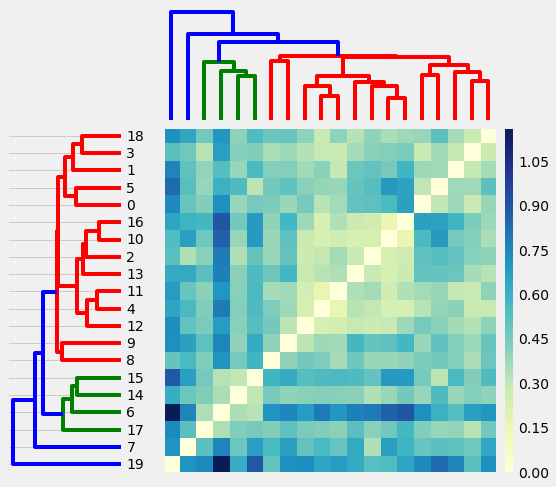

In [14]:
import numpy as np
clusters,vocab,varValues2 = correlationMerge(20,threshold=0.6)


In [11]:
automatic_annotate(clusters,vocab,varValues2)

[2 2 2 2 2 2 1 3 2 2 2 2 2 2 1 1 2 1 2 4]
6 formato debate arroyo país pantalla candidatos usuarios cara vega televisión vieron redes lectores sociales realización electoral digitales diario horario cada
14 enfrentar debate norteamericano presidente luna líder cancelar cara relativamente debates chiste candidato molestar país universidades ayer piedra solo cohetes gobierno
15 pastor campaña factores programas mil televisión tradiciones cara garaje partidos barro política renuncias socialista rápida según agrega electoral conversión políticos
17 cuales hoy entidades sino estadounidense grupo colegios socialista delegado candidato financieros líder llame millones afán parte acerca político sencillo nuevo
All cluster:  digital emisión formato arroyo página cuales pantalla diseñado tv entidades cadenas tuits usuarios estadounidense mundial vega canales colegios andrea pastor
------------------------------
0 hijo campaña esposa si ss mejor entrega hoy guste sido eficaz política mirando cent

In [15]:
def weightWord(tit="",word='hoi'):
    vocab = pickle.load(open('./data/vocab.txt',"rb"))

    #By day
    varValues = np.transpose(np.loadtxt("./data/allDistComb1Day"+str(tit)+".dat"))
    #By freq
    varValues2 = (np.loadtxt("./data/ldaTopics"+str(tit)+".dat"))

    weigthTopics = np.ones(int(tit))
    
    len_vocab = len(vocab)
    # Kind-of efficient way to count words (better to use a dictionary)
    file = re.split(' |\n',word)
    c = Counter(file)
    del c['']
    values = np.zeros(len_vocab)
    count = 0 
    for word in c:
        pos = bi_contains(vocab, word)
        if pos[0]:
            weigthTopics += np.log10(varValues2[:,pos[1]]/np.sum(varValues2[:,pos[1]])*c[word])
            

    weigthTopics = (weigthTopics - np.min(weigthTopics))
    weigthTopics /= np.sum(weigthTopics)
    
    return weigthTopics

    
  

In [16]:
weightWord(20,word="prisión")

array([ 0.03573729,  0.03696589,  0.02545959,  0.42841658,  0.01953572,
        0.04490829,  0.03384607,  0.03924666,  0.0426419 ,  0.03641078,
        0.        ,  0.00907863,  0.02201745,  0.02710525,  0.01979245,
        0.0428206 ,  0.01553519,  0.05109621,  0.00767803,  0.06170741])

./data/Pablo_Iglesias_Podemos.csv
[ 0.05987496  0.0651234   0.04610536  0.05541302  0.02467848  0.11842943
  0.0561438   0.06041897  0.06916527  0.06149525  0.01979053  0.08497182
  0.02865232  0.03529208  0.          0.04478687  0.03363327  0.06908297
  0.01668751  0.05025469]
./data/Albert_Rivera_Ciudadanos.csv
[ 0.06418978  0.05360376  0.04068586  0.06896281  0.02174942  0.09168422
  0.06909723  0.05924703  0.06263472  0.05529668  0.02337447  0.10578842
  0.03535787  0.0380849   0.          0.04636492  0.03211322  0.06744481
  0.0217374   0.04258248]
./data/Mariano_Rajoy_PP.csv
[ 0.06066666  0.0715143   0.04823445  0.05450856  0.02385552  0.10398833
  0.05527035  0.0608746   0.07369993  0.06587909  0.02058397  0.08712669
  0.03061145  0.032647    0.          0.04322539  0.03174407  0.06645116
  0.01476929  0.05434916]
./data/Pedro_Sanchez_PSOE.csv
[ 0.06190728  0.07104502  0.05055442  0.05185506  0.0224995   0.10875232
  0.0519402   0.06245967  0.07004305  0.06363863  0.02104788  0.

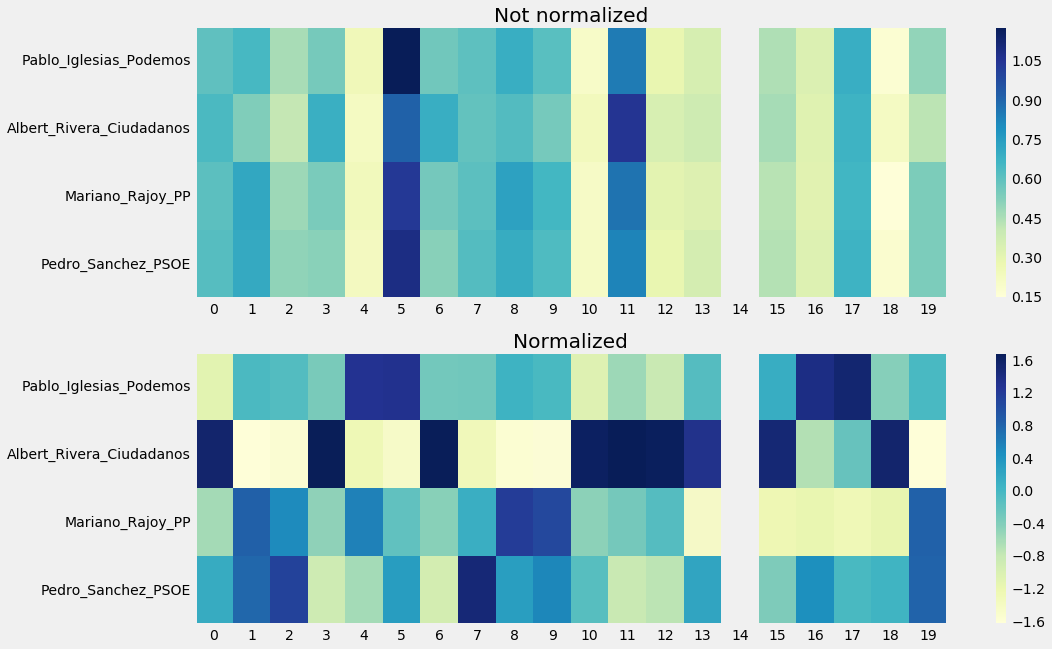

In [338]:
import pandas as pd
import re
from nltk.corpus import stopwords
filenames = ["./data/Pablo_Iglesias_Podemos.csv","./data/Albert_Rivera_Ciudadanos.csv","./data/Mariano_Rajoy_PP.csv","./data/Pedro_Sanchez_PSOE.csv"]

separator_csv = "\t" #tab
header = None
index_col = None 
columns_csv = ["Date","Newspaper","Article"]
column_text = "Article" #leave empty to not get the valence
column_date = "Date" #leave empty to not parse the date
language = "spanish"
extra_stop_words = [_.lower() for _ in ["elpais.com","elpais","Podemos","Pablo","Iglesias","Ciudadanos","Albert","Rivera","Pedro","Sanchez","Sánchez","PSOE","Mariano","Rajoy","PP"]]

cached_stop = set(stopwords.words(language) + extra_stop_words)

num_topics = 20
all_topics = np.zeros((len(filenames),num_topics))
## Fill up
for i,filename in enumerate(filenames):
    print(filename)
    df = pd.read_csv(filename,sep=separator_csv,header=header,index_col=index_col)
    df.columns = columns_csv
    all_messages =  " ".join(df["Article"].values)
    mess = remove_stop_words(remove_punctuation(all_messages),cached_stop)
    all_topics[i,:] = weightWord(num_topics,word=mess)
    print(all_topics[i,:])

all_topics[all_topics==0] = np.NaN

plt.figure(figsize = (15,10))
plt.subplot(2,1,1)
plt.imshow(all_topics*10,interpolation="none",aspect="auto",cmap=plt.cm.YlGnBu)
plt.yticks(range(len(filenames)),[_[_.find("a/")+2:_.find(".csv")] for _ in filenames])
plt.xticks(range(num_topics),[str(_) for _ in range(num_topics)])
plt.grid(False)
plt.colorbar()
plt.title("Not normalized")
for topic_number in range(num_topics):
    all_topics[:,topic_number] = (all_topics[:,topic_number] - np.mean(all_topics[:,topic_number]))/np.std(all_topics[:,topic_number])

plt.subplot(2,1,2)
plt.title("Normalized")
plt.imshow(all_topics,interpolation="none",aspect="auto", cmap=plt.cm.YlGnBu)
plt.yticks(range(len(filenames)),[_[_.find("a/")+2:_.find(".csv")] for _ in filenames])
plt.xticks(range(num_topics),[str(_) for _ in range(num_topics)])
plt.grid(False)
plt.colorbar()
plt.show()

- 0	censo campaña liberal partido dejando si propaganda voto humanidad mejor semejante electoral necesitaba política juventud sido rápida cara calificaron tan aguantar centro soporta hoy casualidad final decimos suárez invierno político
- 1	mil españa residencia dos piel años japón electoral períodos socialista papa gobierno injusticia líder convenio gonzález ama elecciones alma país traje vez felices mayoría utilizando política pobres tres tráfico cuatro
- 2	francés gobierno ejército españa soldados presidente presos francia aires pacto envío ayer brasil partidos inteligencia tras venezolano país aviso ministro contribución parís visitar lucha verso dos afp español mortal exteriores
- 3	detalle cataluña j dos sagrada mas mario gobierno marcos campaña poca elecciones regla independencia permanencia barcelona realizarse ahora entidad presidente finanzas constitucional presentaron partido mexicana cada street aunque jurídicos madrid
- 4	r españa p partido debemos cataluña convivencia gobierno creemos pacto responsabilidades r contradicción reforma daría si lazos ayer islas españoles ayude acuerdo vengo presidente mecanismo país constituido formación separa constitución
- 5	niño años profesores ser docentes si obreros candidato docente gente marina puede localidades ahora humilde vida filósofo solo aula madrid soria aunque santa cuatro comprar política profesión barrio secundaria país
- 6	formato debate emisión país usuarios cara vega candidatos lectores televisión digitales redes horario sociales multimedia tres lector diario gráficos electoral comentarios web bellas través narración programa interacción cita invitados cada
- 7	embajada ataque agente embajada herido policía gol mejor heridos españa montón según grados junto clubes ganar herrera casa edificios dijo escuche ayer jugadores sido homenaje líder isidro alicante oviedo dos
- 8	prestación gobierno satisfacción candidato hijas corrupción villanueva partido comida socialista star presidente suegra día llamando justicia jardines caso sienta cara dependiente madrid cinta líder árbol dos lago ley comiendo pasado
- 9	fiscal reforma ingresos laboral pobreza españa reducción gobierno delitos años empleos millones ajuste programa femenino impuestos indemnización fiscal productivo empleo fijo según empleados déficit adicionales año acordar comisión sucio economía
- 10	pretensiones partido cuándo federal características si halla general post secretario llegaba socialistas inconveniente congreso imposición comité estatutos gobierno mandan socialista page líder danza ayer humildad fuerzas ordinaria díaz iremos cataluña
- 11	dictadura política falso españa monarquía político cuotas si tratado poder añadido partido inmediatamente partidos juegos solo categoría bien siglos ahora ciudadana sido caballo democracia dignidad forma sueño electoral contradicciones española
- 12	l gobierno daño si retos elecciones factor partido pc mayoría ampliamente partidos relativa fuerzas castigo formar conduce votos descenso puede deseos aunque sumamente ser legislativo políticas acabamos campaña conclusiones fuerza
- 13	dure presidente paquete gobierno manejar elecciones requieren líder tope funciones externo rey constituyen españa regalo ahora instalaciones si ejecutar semana echando dirigentes disculpa dos registrarse quiere lento política amplitud ayer
- 14	escucho debate gustan líder hagamos presidente numerosos país norteamericano cara armada candidato relativamente debates métodos ayer verdaderamente gobierno conectados campaña destinados solo valorado candidatos venga partido personalmente tres miren lunes
- 15	entretenimiento campaña formatos programas factores televisión ruiz partidos pop política aventura políticos aguilar candidatos vínculo equipo deportivos electoral conversión tras gratuitos entretenimiento vera cada veracruz medios barato nuevos llego socialista
- 16	reglamento congreso senadores cámara requisitos mesa gutiérrez acuerdo cumplen diputados proposiciones grupos marcelo dos nombramiento grupo raíz presidente naturales ayer elige partidos juramento partido disolución legislatura solos constitución variación lópez
- 17	trinidad socialista bolsa gobierno delegado secretario cortés candidato serrano general oo millones financiero frente rodrigo dos conciencia debate mortalidad grupo enojo parte rutina aunque generalmente pasado estudiantes líder volkswagen luis
- 18	región partido municipio elecciones tomás votos distritos resultado llame dos cena madrid aparente solo básicamente voto girona años cae fuerza pierden diputados registrada socialistas original ayer fidelidad generales quinta menos
- 19	condena presidente amistad candidato cárcel líder detenido ayer contento si f violencia coger gobierno fomento mas agradezco mensaje antecedentes escribió dependencias secretario afecto tras tremendo solidaridad grabación dijo recibo condena